In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
data = pd.read_csv('/Users/dubrov_arseniy/Desktop/Нетология/Data Scientist/ML/10. Feature Selection/HW/kobe.csv')

In [3]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [5]:
#Посмотрим сколько всего строк и столбцов
data.shape

(30697, 25)

In [6]:
#Посмотим на типы данных и пропуски
pd.DataFrame(data = {"type":data.dtypes,
                     "is null":data.isnull().sum().values},
             index = data.dtypes.index)

,type,is null
action_type,object,0
combined_shot_type,object,0
game_event_id,int64,0
game_id,int64,0
lat,float64,0
loc_x,int64,0
loc_y,int64,0
lon,float64,0
minutes_remaining,int64,0
period,int64,0


Наша целевая переменная (shot_made_flag) имеет пропуски и с ними нужно как-то поработать. У нас почти 15% данных без значений, пропуски

In [7]:
#Посмотрим разброс данных в целевой переменной 
#Видим, что у нас угадывается два класса 0 и 1

data.shot_made_flag.unique()

array([nan,  0.,  1.])

In [8]:
#Попробуем их просто удалить

df2 = data.copy(deep=True)
df2.dropna(subset = ['shot_made_flag'], inplace = True)
df2['shot_made_flag'].isnull().sum()

0

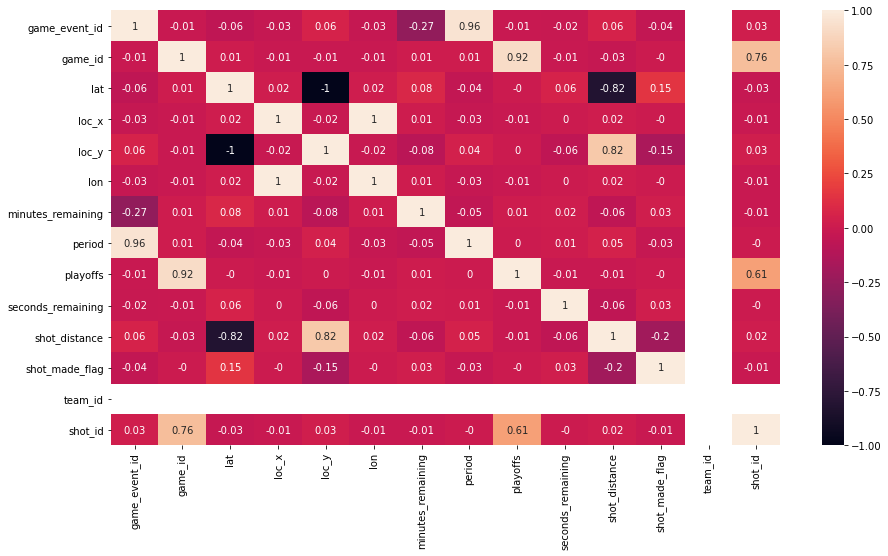

In [9]:
#Посмотрим матрицу корреляции. 
#Видим, что нет признаков, которые сильно бы влияли на нашу целовую переменную

cor1 = df2.corr().round(2)

plt.figure(figsize=(15, 8))
sns.heatmap(cor1, annot = True)
plt.show()


Теперь посмотрим внимательно на каждый признак и будем работать с ним отдель

In [10]:
#Признак team_id  и team_name имеет одну записать только, которая всегда повторяется. Ее можно удалить
#Признаки ID игры, мероприятия и shot_id не очень важные, как мне кажется. Удалим их аналогично

df2.drop(columns = ['team_id'], axis = 1, inplace  = True)
df2.drop(columns = ['team_name'], axis = 1, inplace  = True)
df2.drop(columns = ['game_event_id','game_id', 'shot_id'], axis = 1, inplace  = True)
df2.columns

Index(['action_type', 'combined_shot_type', 'lat', 'loc_x', 'loc_y', 'lon',
       'minutes_remaining', 'period', 'playoffs', 'season',
       'seconds_remaining', 'shot_distance', 'shot_made_flag', 'shot_type',
       'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_date',
       'matchup', 'opponent'],
      dtype='object')

In [11]:

df2.describe()

,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag
count,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000
mean,33.953043,7.148422,91.257345,-118.262652,4.886796,2.520800,0.146243,28.311554,13.457096,0.446161
std,0.088152,110.073147,88.152106,0.110073,3.452475,1.151626,0.353356,17.523392,9.388725,0.497103
min,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,33.884300,-67.000000,4.000000,-118.336800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000
50%,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000
75%,34.040300,94.000000,160.000000,-118.175800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000
max,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x7fe98043b730>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe98043bdf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe98043b3d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe98044b4f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe98044b850>],
 'means': []}

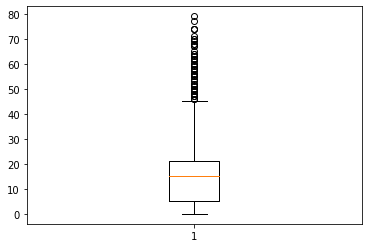

In [12]:
#Посмотрим есть ли выборсы
#Возьмем например признак shot_distance
#Мы видим, что как будто есть выбросы, но если посмотреть на целевую переменною, то мы увидим, что и забитые мячи есть
#То есть на большой дистанции Коби забивал мячи и исклюяать этот фактор нельзя. 
#Аналогичная история и с другими признакми, поэтому я бы не исклюяал бы выбросы
plt.boxplot(df2['shot_distance'])


Нужно работать с признаками и делать их категориальными

In [13]:

#Сделаем ф-ю обработки категориальных переменных 

def get_one_hot(X, cols):
    for each in cols:
        dummies = pd.get_dummies(X[each], prefix=each, drop_first=False)
        X = pd.concat([X, dummies], axis=1)
    return X

In [14]:
# Выделим из сезона год и удалим признак season

df2['year_season'] = df2['season'].str[:4]
df2.drop(columns = ['season'], inplace = True)
df2.tail(2)

,action_type,combined_shot_type,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent,year_season
30695,Jump Shot,Jump Shot,33.7773,31,267,-118.2388,2,4,1,10,26,0.0,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,2000-06-19,LAL vs. IND,IND,1999
30696,Jump Shot,Jump Shot,33.9723,1,72,-118.2688,0,4,1,39,7,0.0,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,2000-06-19,LAL vs. IND,IND,1999


In [15]:
# Выделим из game_date год 

df2['new_game_date'] = df2['game_date'].str[:4]
df2.drop(columns = ['game_date'], inplace = True)
df2.head(2)


,action_type,combined_shot_type,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent,year_season,new_game_date
1,Jump Shot,Jump Shot,34.0443,-157,0,-118.4268,10,1,0,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,LAL @ POR,POR,2000,2000
2,Jump Shot,Jump Shot,33.9093,-101,135,-118.3708,7,1,0,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,LAL @ POR,POR,2000,2000


In [16]:
# Признак shot_type переведем в label encoding
le = LabelEncoder()
le.fit(df2['shot_type'])
df2['new_shot_type'] = le.transform(df2['shot_type'])
df2.drop(columns = ['shot_type'], inplace = True)
df2.tail(2)


,action_type,combined_shot_type,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent,year_season,new_game_date,new_shot_type
30695,Jump Shot,Jump Shot,33.7773,31,267,-118.2388,2,4,1,10,26,0.0,Center(C),Above the Break 3,24+ ft.,LAL vs. IND,IND,1999,2000,1
30696,Jump Shot,Jump Shot,33.9723,1,72,-118.2688,0,4,1,39,7,0.0,Center(C),In The Paint (Non-RA),Less Than 8 ft.,LAL vs. IND,IND,1999,2000,0


Сгруппируем shot_distance. Для этого запишем функцию и пременем ее

In [17]:
def distance_group(x):
    if x['shot_distance'] >=60:
        return 'More then 60'
    if x['shot_distance'] < 60 and x['shot_distance'] >= 40:
        return "60-40"
    if x['shot_distance'] < 40 and x['shot_distance'] >= 30:
        return "40-30"
    if x['shot_distance'] < 30 and x['shot_distance'] >= 20:
        return "30-20"
    if x['shot_distance'] < 20 and x['shot_distance'] >= 10:
        return "20-10"
    if x['shot_distance'] < 10 and x['shot_distance'] >= 5:
        return "10-5"
    if x['shot_distance'] < 5:
        return "Less then 5"

In [18]:
df2['new_distance'] = df2.apply(distance_group, axis = 1)
df2['new_distance'].drop(columns = 'shot_distance', inplace = True)

In [19]:
#Переведем в категориальные переменную через one_hot enconding

df2 = get_one_hot(df2, ['combined_shot_type'])
df2 = get_one_hot(df2, ['action_type'])
df2 = get_one_hot(df2, ['shot_zone_basic'])
df2 = get_one_hot(df2, ['shot_zone_range'])
df2 = get_one_hot(df2, ['new_game_date'])
df2 = get_one_hot(df2, ['shot_zone_area'])
df2 = get_one_hot(df2, ['new_distance'])
df2 = get_one_hot(df2, ['opponent'])


df2.drop(columns = ['combined_shot_type'], inplace = True)
df2.drop(columns = ['action_type'], inplace = True)
df2.drop(columns = ['shot_zone_basic'], inplace = True)
df2.drop(columns = ['shot_zone_range'], inplace = True)
df2.drop(columns = ['new_game_date'], inplace = True)
df2.drop(columns = ['shot_zone_area'], inplace = True)
df2.drop(columns = ['new_distance'], inplace = True)
df2.drop(columns = ['matchup'], inplace = True)
df2.drop(columns = ['opponent'], inplace = True)


df2.head()

,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,...,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
1,34.0443,-157,0,-118.4268,10,1,0,22,15,0.0,...,0,0,1,0,0,0,0,0,0,0
2,33.9093,-101,135,-118.3708,7,1,0,45,16,1.0,...,0,0,1,0,0,0,0,0,0,0
3,33.8693,138,175,-118.1318,6,1,0,52,22,0.0,...,0,0,1,0,0,0,0,0,0,0
4,34.0443,0,0,-118.2698,6,2,0,19,0,1.0,...,0,0,1,0,0,0,0,0,0,0
5,34.0553,-145,-11,-118.4148,9,3,0,32,14,0.0,...,0,0,1,0,0,0,0,0,0,0


Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются.

In [20]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [21]:
#Отберем наши X и y

X = df2[df2.columns]
X.drop(columns = ['shot_made_flag'], inplace = True)

y = df2['shot_made_flag']

In [22]:
#Разделим наши дынные на обучение и тест

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


In [23]:
#Создаем объект StandardScaler и прогоняем наши данные для уменьшения разброса 

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [24]:
#Мы определяемся с нашими данными, которые мы будем хранить в нашей обученной модели для того, 
#чтобы по ней построить как меняется график
#lg_r - тут будет храниться линейная регрессия Ridge
#lg_l - тут будет храниться линейная регрессия Lasso
#pred_r предсказания, которые сделала Ridge
#pred_l предсказания, которые сделала Lasso
# list_r, list_l коэффициент регулзации для одной и второй модели 


lg_r,lg_l,pred_r,pred_l = [], [], [], []
list_r=list(1.5**np.linspace(-20,20,100))
list_l=list(2**np.linspace(-20,20,100))

In [25]:
#Тут мы начинаем эти модели обучать 

for i in range(len(list_r)):
    m_r = Ridge(alpha=list_r[i]).fit(X_train, y_train)
#Создаем модель Ridge регрессии, с коэф list_r и обучаем на наших данных 

    m_l = Lasso(alpha=list_l[i]).fit(X_train, y_train)
#Создаем модель Lasso регрессии, с коэф list_r и обучаем на наших данных

    lg_r.append(m_r)
#Обученные модели сохраняем в список
    
    pred_r.append(m_r.coef_)
#Сохраняем те коэффициенты, которая предала наша модель нашим признакам 
 
    lg_l.append(m_l)
    pred_l.append(m_l.coef_)    
    
#Когда наша модель обучается, она подбирает коэф нашим признакам. 
#И эти коэф мы сохраняем в список и потом сможем построить график

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 806.7070445461729, tolerance: 0.44459922166008664
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 800.7666649660607, tolerance: 0.44459922166008664
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 807.5045246897278, tolerance: 0.44459922166008664
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Convergence

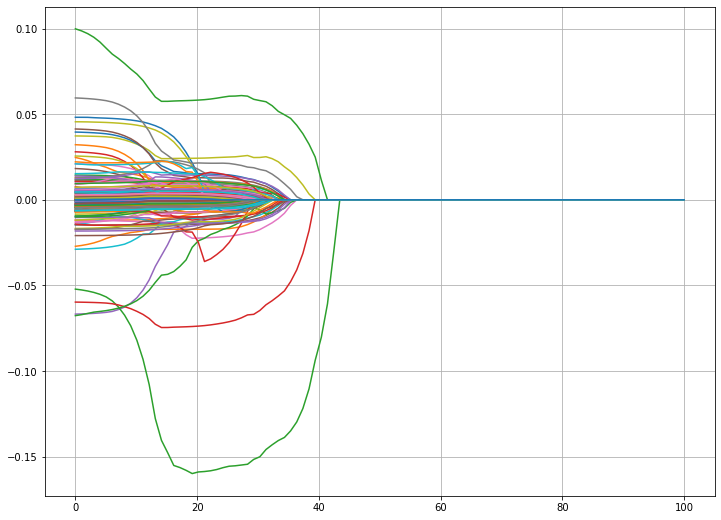

In [40]:
#Посомотрм на сами коэффициенты, что с ними происходило, когда мы повышали коэф регулязации
#Сначала были большие и потом все уменьшались и уменьшались
#Поочередно они все уходили в 0

plt.figure(figsize=(12,9))
x_l = np.linspace(0,len(pred_l),len(pred_l))
for i in np.vstack(pred_l).T:
    plt.plot(x_l,np.sign(i)*np.abs(i)) 
      
plt.grid()




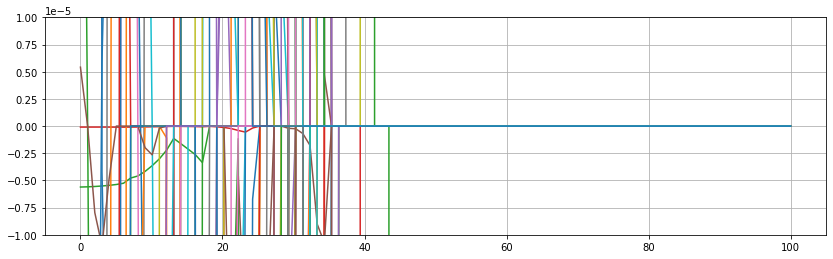

In [41]:
#Зеленый признак самый важный, он обнулился в самый последний

plt.figure(figsize=[14,4])
x_l = np.linspace(0,len(pred_l),len(pred_l))
for i in np.vstack(pred_l).T:
    plt.plot(x_l,np.sign(i)*np.abs(i))
plt.ylim(-0.00001,0.00001)   
plt.grid() 